## Introduction: Background Theory and Analysis Rationale

   There has been in recent years a flourishing of papers about Machine Learning (ML) and Deep Learning (DL) Techniques applied to Finance. Many of them claim pretty astonishing results in terms of their ability to predict stock prices. 
Such claims raise significant doubts among Finance Practitioners, who are familiar with the complexity of Financial Markets stemming from many causes. The main three are the non-stationarity of the prodesses, their not IID nature, and the real-time feedback-loop effects due to the agents mimiking the most effective strategies.
    The main goal of this little research is to try to replicate the performance claimed by certain authors that a fairly simple RNN can accurately predict stock prices time serieses (see for example [1] and [2]).
    The work builds on the theoretical work of Lopez de Prado [3], who established the correct framework to proper address the specific characteristics of financial data. In fact without proper pre-processing and segmentation of Training/Validation/Testing subsets (among others), the ML and DL techniques will be riddled with false discoveries stemming from massive leaking information from the training/validation to the test set.
    The other main refererence of this work is the paper by German Creamer [4] on Automated Trading with Boosting, where he selected a list of technical indicator and built trading strategies using Alternate Decision Trees with ADA Boosting. We use the same set of technical indicators as the features to predict the Stock Price. In doing so we circumvent two of the main flaws we have seen in many papers: using a non-stationary time series (prices) and obtaining false positive result due to basic leaking of information. By not using the stock prices among the features, but various manipulations of them, we are drastically reduce the impact of these problems.
    One point is worth stressing: we apply particular care in separating training, validation and test set using, among others, the "embargo" technique suggested by de Prado.
    We tried three differerent RNN architectures: a simple 6 layers RNN, a 4 layers LSTM and a 3 layers Bidirectional-LSTM. They performed increasingly better, as it was expected, but the improvements were marginal and the results were very poor. I fact their respective percentage average prediction errors weere, respectively: 40.3%, 39.4% and 38.3%. These kind of performances are almost two order of magnitude worst than the results claimed in the papers referenced, but more in line with what finance practitioners actually experience in real world implementation.
    In conclusion, this work, after carefully applying technique to avoid information leaking, was not able to obtain significant results of Stock Prices prediction. 


## Bibliography
[1] J. Sirignano, R. Cont, Using features of price formation in financial markets:     perspectives from Deep Learning, JQF, 2019
<br>
[2] D. Tashiro et all, Encoding High-frequency Order Information and Prediction of Short-term Stock Price by Deep Learning, JQF, 2019
<br>
[3] M. Lopez de Prado, Advances in Financial Machine Learning, "Wiley", 2018
<br>
[4] G. Creamer, Y. Freund, Automated Trading with Boosting and Expert Weighting, 2006
<br>
[5] S. Gu, B. Kelly and D. Xiu, Empirical Asset Pricing via Machine Learning, 2019
<br>
[6] R. Koijen, S. Van Nieuwerburgh, The Factor Zoo, 2019

## Data Collection, Visualization and Pre-processing

In [490]:
import pandas_datareader as web
import pandas as pd
import numpy as np
import math as m
import talib as tb
import ta
from talib import RSI, BBANDS
import matplotlib.pyplot as plt
import quandl
quandl.ApiConfig.api_key = 'SwJn1a92gH24F1sqonbw'

In [139]:
# Fetching of Apple Stock data from 01/02/2014 to 10/31/2019

start = '2014-01-02'
end = '2019-10-31'

symbol = 'AAPL'
max_holding = 100
price = web.quandl.QuandlReader(symbol, api_key= 'SwJn1a92gH24F1sqonbw',
                       start=start, end=end)

In [140]:
AAPL = price.read()
AAPL = AAPL.iloc[::-1]
AAPL = AAPL.dropna()

In [141]:
AAPL['AdjClose'][0:5].ewm

<bound method NDFrame._add_series_or_dataframe_operations.<locals>.ewm of Date
2014-01-02    73.523423
2014-01-03    71.908415
2014-01-06    72.300536
2014-01-07    71.783135
2014-01-08    72.238063
Name: AdjClose, dtype: float64>

In [142]:
AAPL.head()

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2014-01-02,555.68,557.03,552.021,553.1300,8381600.0,0.0,1.0,73.862376,74.041821,73.376012,73.523423,58671200.0
2014-01-03,552.86,553.70,540.430,540.9800,14016700.0,0.0,1.0,73.487534,73.599189,71.835308,71.908415,98116900.0
2014-01-06,537.45,546.80,533.600,543.9300,14736100.0,0.0,1.0,71.439198,72.682024,70.927447,72.300536,103152700.0
2014-01-07,544.32,545.96,537.925,540.0375,11328900.0,0.0,1.0,72.352376,72.570369,71.502337,71.783135,79302300.0
2014-01-08,538.81,545.56,538.690,543.4600,9233200.0,0.0,1.0,71.619973,72.517200,71.604022,72.238063,64632400.0


In [143]:
Adjclose = AAPL['AdjClose'].values
up, mid, low = BBANDS(Adjclose, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
rsi = RSI(Adjclose, timeperiod=14)
print("RSI (first 10 elements)\n", rsi[14:24])

RSI (first 10 elements)
 [51.70286416 46.09842581 48.72138214 32.04293703 30.57017126 30.31753975
 30.83768162 31.46405184 36.31303279 38.75551116]


In [144]:
def bbp(X):
    up, mid, low = BBANDS(Adjclose, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (X['AdjClose'] - low) / (up - low)
    return bbp

In [146]:
holdings = pd.DataFrame(index=AAPL.index, data={'Holdings': np.array([np.nan] * AAPL.index.shape[0])})
holdings.loc[((rsi< 30) & (bbp(AAPL) < 0)), 'Holdings'] = max_holding
holdings.loc[((rsi > 70) & (bbp(AAPL) > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)
holdings['Order'] = holdings.diff()
holdings.dropna(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


100.0
2015-07-09 00:00:00
100.0
2016-04-27 00:00:00
100.0
2018-02-02 00:00:00


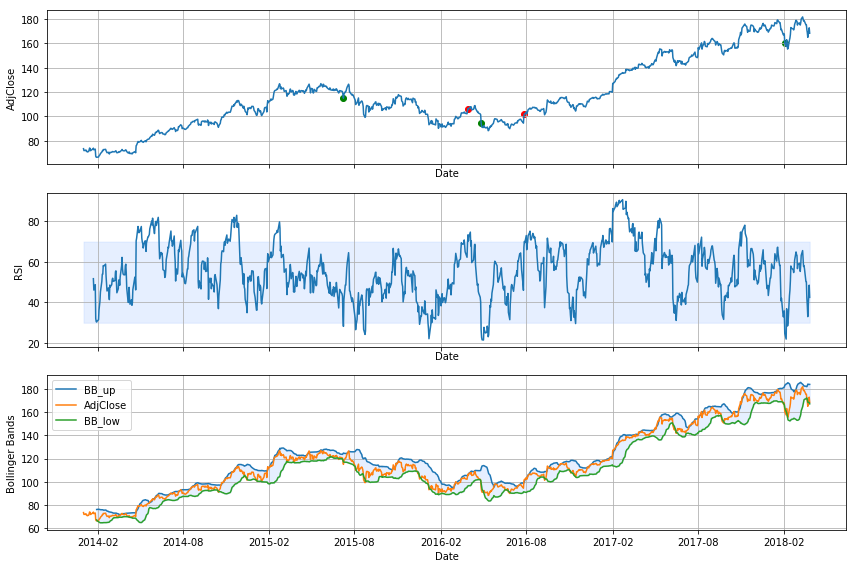

In [148]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
ax0.plot(AAPL.index, Adjclose, label='AdjClose')
ax0.set_xlabel('Date')
ax0.set_ylabel('AdjClose')
ax0.grid()
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        print(order)
        print(day)
        ax0.scatter(x=day, y=AAPL.loc[day, 'AdjClose'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=AAPL.loc[day, 'AdjClose'], color='red')

ax1.plot(AAPL.index, rsi, label='RSI')
ax1.fill_between(AAPL.index, y1=30, y2=70, color='#adccff', alpha='0.3')
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(AAPL.index, up, label='BB_up')
ax2.plot(AAPL.index, Adjclose, label='AdjClose')
ax2.plot(AAPL.index, low, label='BB_low')
ax2.fill_between(AAPL.index, y1=low, y2=up, color='#adccff', alpha='0.3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.legend()
ax2.grid()

fig.tight_layout()
plt.show()

## Technical Indicators

### Price Indicators

In [149]:
# 0) Log Price
def LP(X):
    y = ta.others.daily_log_return(X.AdjClose)
    return y

# 1) Simple Moving Average 
def SMA(X, n):
    y = X.AdjClose.rolling(window=n).mean()
    return y
    
AAPL['AdjClose'].rolling(window=10).mean()[20:30] #Preferred
AAPL['AdjClose'].rolling(window=16).mean()
AAPL['AdjClose'].rolling(window=22).mean()

# 2) Exponential Moving Average
AAPL['AdjClose'].ewm(alpha=0.9).mean()[20:30]
AAPL['AdjClose'].ewm(alpha=0.84).mean()
AAPL['AdjClose'].ewm(alpha=0.78).mean()

def EMA(X, n):
    y = ta.trend.ema_indicator(X.AdjClose, n=n)
    return y

# tb.EMA(AAPL['AdjClose'], timeperiod=20)


In [150]:
# 3) Bollinger Bands
up, mid, low =tb.BBANDS(AAPL['AdjClose'])
pd.DataFrame(data={'Upper Band':up, 'Middle':mid, 'Lower Band':low})[20:30]

su = ta.volatility.bollinger_hband(AAPL['AdjClose'])
mez = ta.volatility.bollinger_mavg(AAPL['AdjClose'])
giu = ta.volatility.bollinger_lband(AAPL['AdjClose'])
pd.DataFrame(data={'Upper Band':su, 'Middle':mez, 'Lower Band':giu})[20:30]

def BollingerBands(X):
    su = ta.volatility.bollinger_hband(X.AdjClose)
    mez = ta.volatility.bollinger_mavg(X.AdjClose)
    giu = ta.volatility.bollinger_lband(X.AdjClose)
    return pd.DataFrame({'Up':su, 'Price':mez, 'Down':giu})

In [151]:
BollingerBands(AAPL)[20:30]

,Up,Price,Down
Date,,,
2014-01-31,76.267812,71.334379,66.400946
2014-02-03,76.397526,71.072189,65.746853
2014-02-04,76.334961,70.838645,65.342328
2014-02-05,76.256242,70.656225,65.056208
2014-02-06,76.094568,70.470798,64.847028
2014-02-07,76.004720,70.379438,64.754156
2014-02-10,75.997838,70.374109,64.750379
2014-02-11,76.037550,70.396835,64.756120
2014-02-12,75.928062,70.348447,64.768833


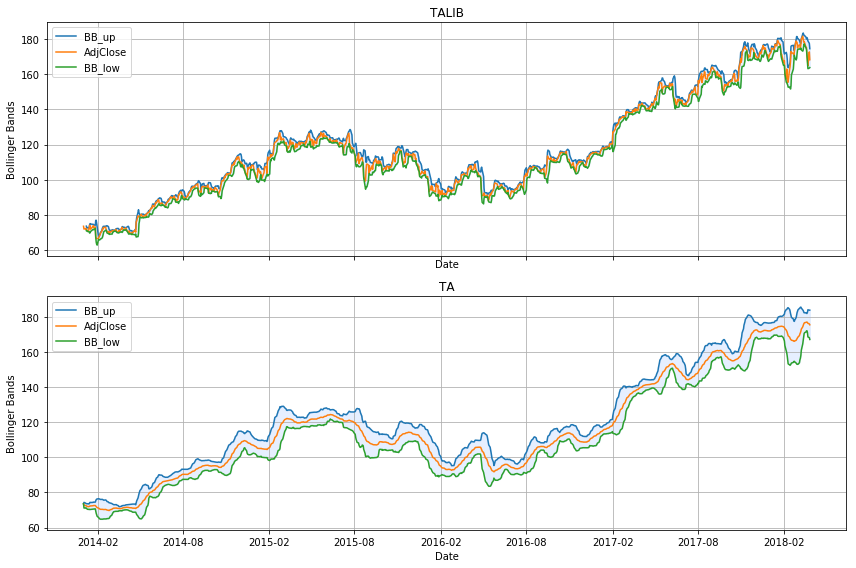

In [152]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

ax1.plot(AAPL.index, up, label='BB_up')
ax1.plot(AAPL.index, Adjclose, label='AdjClose')
ax1.plot(AAPL.index, low, label='BB_low')
ax1.fill_between(AAPL.index, y1=low, y2=up, color='#adccff', alpha='0.3')
ax1.set_xlabel('Date')
ax1.set_ylabel('Bollinger Bands')
ax1.set_title('TALIB')
ax1.legend()
ax1.grid()

ax2.plot(AAPL.index, su, label='BB_up')
ax2.plot(AAPL.index, mez, label='AdjClose')
ax2.plot(AAPL.index, giu, label='BB_low')
ax2.fill_between(AAPL.index, y1=giu, y2=su, color='#adccff', alpha='0.3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.set_title('TA')
ax2.legend()
ax2.grid()

fig.tight_layout()
plt.show()

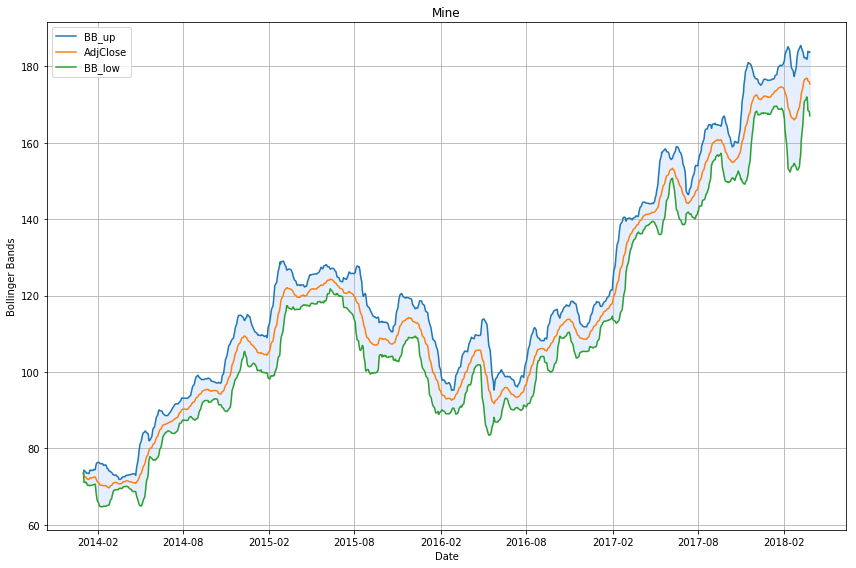

In [153]:
fig, (ax2) = plt.subplots(1, 1, sharex=True, figsize=(12, 8))

ax2.plot(AAPL.index, BollingerBands(AAPL)['Up'], label='BB_up')
ax2.plot(AAPL.index, BollingerBands(AAPL)['Price'], label='AdjClose')
ax2.plot(AAPL.index, BollingerBands(AAPL)['Down'], label='BB_low')
ax2.fill_between(AAPL.index, y1=giu, y2=su, color='#adccff', alpha='0.3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.set_title('Mine')
ax2.legend()
ax2.grid()

fig.tight_layout()
plt.show()

In [154]:
# 4) Price to Upper Bollinger

def PBolU(X, n):
    y = X.AdjClose/ta.volatility.bollinger_hband(X.AdjClose,n)
    return y

# 5) Price to Lower Bollinger
def PBolL(X, n):
    y = X.AdjClose/ta.volatility.bollinger_lband(X.AdjClose,n)
    return y

In [155]:
type(PBolU(AAPL,20))

pandas.core.series.Series

### Momentum And Oscillation Indicators

In [156]:
# 6) MOM
def MOM(X, n):
    y = X.AdjClose.diff(n)
    return y

In [157]:
# 7) MomEMA
def MomEMA(X, n, alpha):
    y = MOM(X, n) / MOM(X, n).ewm(alpha=alpha).mean()
    return y

In [158]:
#  8) ACCEL
def ACCEL(X, n):
    y = MOM(X,n).diff(1)
    return y

In [159]:
# 9) ROC

def ROC(X, n):
    y = ta.momentum.roc(X.AdjClose,n)
    return y

In [160]:
# 10) MACD
def MACD(X, s, f):
    y = EMA(X, s) - EMA(X, f)
    return y

In [161]:
# 11) RSI
def RSI(X, n):
    y = ta.momentum.rsi(X.AdjClose, n=n)
    return y

### Stochastic Oscillators

In [162]:
# 12) FAST%K
def FASTK(X, n):
    y = pd.Series(np.zeros(len(X)), index=X.index)
    for i in range(len(X)):
        p = X.AdjClose.iloc[min(i+1,len(X)-1)]
        mm = max(X.AdjHigh.iloc[max(0,i-n+1): i+1])
        mn = min(X.AdjLow.iloc[max(0,i-n+1): i+1])
        yi = ((p-mn)/(mm-mn))
        y.iloc[i] = yi
    return y

In [163]:
# 13) Williams
def WILL(X, n):
    y = pd.Series(np.zeros(len(X)), index=X.index)
    for i in range(len(X)):
        p = X.AdjClose.iloc[min(i+1,len(X)-1)]
        mm = max(X.AdjHigh.iloc[max(0,i-n+1): i+1])
        mn = min(X.AdjLow.iloc[max(0,i-n+1): i+1])
        yi = ((mm-p)/(mm-mn))
        y.iloc[i] = yi
    return y

In [164]:
# 14) Money Flow Index
def MFI(X, n):
    y = ta.momentum.money_flow_index(X.AdjHigh, X.AdjLow, X.AdjClose, X.AdjVolume, n)
    return y

In [165]:
ta.others.daily_log_return(AAPL.AdjClose)[20:30].std()

0.6599969669744274

In [166]:
# 15) Chaikin Volatility
def CHAI(X, n, l):
    et = ta.trend.ema_indicator(X.AdjHigh-X.AdjLow, n=n)
    etl = ta.trend.ema_indicator(X.AdjHigh-X.AdjLow, n=n+l)
    y = et/etl -1
    return y

In [167]:
# 16) Sharpe Ratio
def SR(X,n):
    y = pd.Series(np.zeros(len(X)), index=X.index)
    for i in range(len(X)):
        lr = ta.others.daily_log_return(X.AdjClose.iloc[max(0,i-n+1): i+1])
        mn = lr.mean()
        std = lr.std()
        yi = mn/std
        y.iloc[i] = yi
    return y
   

### Volume Indicators

In [168]:
# 17) On Balance Volume
def OBV(X):
    y = ta.volume.on_balance_volume(X.AdjClose, X.AdjVolume)
    return y

In [169]:
# 18) Accumulation/Distribution Line
def ADL(X):
    y = ta.volume.acc_dist_index(X.AdjHigh, X.AdjLow, X.AdjClose, X.AdjVolume)
    return y

In [170]:
# 19) Chaikin Oscillator
def CHO(X):
    y = ta.trend.ema_indicator(ADL(X), 3) - ta.trend.ema_indicator(ADL(X), 10)
    return y

In [172]:
# 20) Negative Volume Index
def NVO(X):
    y = ta.volume.negative_volume_index(X.AdjClose, X.AdjVolume)
    return y

## Data Preparation

In [256]:
# Normalizing the Feature Data
mean = AAPL.mean(axis=0)

In [257]:
mean.shape

(12,)

In [173]:
lag = 1
lenght_train = 700
lenght_valid = 140
embargo = 20

X_train = AAPL[0:lenght_train]
y_train = AAPL[lag:lenght_train+lag]
X_valid = AAPL[lenght_train + embargo:lenght_train + embargo + lenght_valid]
y_valid = AAPL[lenght_train + embargo + lag:lenght_train + embargo + lenght_valid + lag]
X_test = AAPL[lenght_train + embargo + lenght_valid + embargo:1063]
y_test = AAPL[lenght_train + embargo + lenght_valid + embargo + lag:]

lenght_test = len(y_test)

In [174]:
# Initialize the Training, Validation and Test Matrices and vectors

MX_train = np.zeros((lenght_train, 23))
My_train = np.zeros((lenght_train, 1))
MX_valid = np.zeros((lenght_valid, 23))
My_valid = np.zeros((lenght_valid, 1))
MX_test = np.zeros((lenght_test, 23))
My_test = np.zeros((lenght_test, 1))

In [175]:
ZeroIndicators = [LP, OBV, ADL, CHO, NVO]
SingleIndicators = [SMA, EMA, PBolU, PBolL, MOM, ACCEL, ROC, RSI, FASTK, WILL,
             MFI, SR]

In [176]:
# Create the X Training Matrix
# Please not that in the Input Matrices there aren't the Prices, because it is a well
# known fact in finance that the prices are not stationary and therefore using them 
# as predictor will create spurious results
for i, Tech in enumerate(ZeroIndicators):
    MX_train[:, i] = Tech(X_train)

for i, Tech in enumerate(SingleIndicators):
    n = 10
    MX_train[:, i + 5] = Tech(X_train, n)

MX_train[:, 17] = MomEMA(X_train, n=10, alpha=0.9)
MX_train[:, 18] = MACD(X_train, f=12, s=18)
MX_train[:, 19] = CHAI(X_train, n=10, l=10)
MX_train[:, 20:] = BollingerBands(X_train)
    

In [181]:
# Create the X Validation Matrix

for i, Tech in enumerate(ZeroIndicators):
    MX_valid[:, i] = Tech(X_valid)

for i, Tech in enumerate(SingleIndicators):
    n = 10
    MX_valid[:, i + 5] = Tech(X_valid, n)

MX_valid[:, 17] = MomEMA(X_valid, n=10, alpha=0.9)
MX_valid[:, 18] = MACD(X_valid, f=12, s=18)
MX_valid[:, 19] = CHAI(X_valid, n=10, l=10)
MX_valid[:, 20:] = BollingerBands(X_valid)
    

In [185]:
# Create the X Test Matrix

for i, Tech in enumerate(ZeroIndicators):
    MX_test[:, i] = Tech(X_test)

for i, Tech in enumerate(SingleIndicators):
    n = 10
    MX_test[:, i + 5] = Tech(X_test, n)

MX_test[:, 17] = MomEMA(X_test, n=10, alpha=0.9)
MX_test[:, 18] = MACD(X_test, f=12, s=18)
MX_test[:, 19] = CHAI(X_test, n=10, l=10)
MX_test[:, 20:] = BollingerBands(X_test)
    

In [209]:
#  Check that the rwos from 19th on do not have nan's
print('Number of nan in MX_train: '+ str(np.sum(np.isnan(MX_train[19:]))))
print('Number of nan in MX_valid: '+ str(np.sum(np.isnan(MX_valid[19:]))))
print('Number of nan in MX_test: '+ str(np.sum(np.isnan(MX_test[19:]))))

Number of nan in MX_train: 0
Number of nan in MX_valid: 0
Number of nan in MX_test: 0


In [258]:
# Purge the Matrices from nan lines: since the values are small, replacing nan with zero
# will spuriosly skew the dataset 
PMX_train = MX_train[19:]
PMX_valid = MX_valid[19:]
PMX_test = MX_test[19:]

# Normalizing the 3 dataset separately to avoid information leaking 

mean_tr = PMX_train.mean(axis=0)
mean_v = PMX_valid.mean(axis=0)
mean_te = PMX_test.mean(axis=0)
PMX_train -= mean_tr
PMX_valid -= mean_v
PMX_test -= mean_te

std_tr = PMX_train.std(axis=0)
std_v = PMX_valid.std(axis=0)
std_te = PMX_test.std(axis=0)
PMX_train /= std_tr
PMX_valid /= std_v
PMX_test /= std_te

# Creating Tensors
TX_train = np.reshape(PMX_train, (PMX_train.shape[0], 1, PMX_train.shape[1]))
TX_valid = np.reshape(PMX_valid, (PMX_valid.shape[0], 1, PMX_valid.shape[1]))
TX_test = np.reshape(PMX_test, (PMX_test.shape[0], 1, PMX_test.shape[1]))

In [266]:
TX_train.shape

(681, 1, 23)

In [267]:
# Creating the corresponding labels, which are the Adjusted Closed Prices, the variable
# we want to predict
My_train = X_train.AdjClose
My_valid = X_valid.AdjClose
My_test = X_test.AdjClose
PMy_train = My_train[19:]
PMy_valid = My_valid[19:]
PMy_test = My_test[19:]

## Models Generation

### Simple 6 layers RNN

In [229]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.optimizers import RMSprop

In [487]:
state_dim = 200
feat_num = 23

model_1 = Sequential()
model_1.add(SimpleRNN(state_dim, input_shape=(None, feat_num),return_sequences=True))
model_1.add(SimpleRNN(state_dim,return_sequences=True, dropout=0.2))
model_1.add(SimpleRNN(state_dim,return_sequences=True, dropout=0.2))
model_1.add(SimpleRNN(state_dim,return_sequences=True, dropout=0.2))
model_1.add(SimpleRNN(state_dim,return_sequences=True, dropout=0.2))
model_1.add(SimpleRNN(state_dim,return_sequences=False, dropout=0.2))
model_1.add(Dense(1))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_38 (SimpleRNN)    (None, None, 200)         44800     
_________________________________________________________________
simple_rnn_39 (SimpleRNN)    (None, None, 200)         80200     
_________________________________________________________________
simple_rnn_40 (SimpleRNN)    (None, None, 200)         80200     
_________________________________________________________________
simple_rnn_41 (SimpleRNN)    (None, None, 200)         80200     
_________________________________________________________________
simple_rnn_42 (SimpleRNN)    (None, None, 200)         80200     
_________________________________________________________________
simple_rnn_43 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 201       
Total para

In [488]:
model_1.compile(optimizer=RMSprop(), loss='mae')

In [489]:
history_1 = model_1.fit(TX_train, PMy_train,
                                epochs=100,
                                batch_size=64,
                                validation_data= (TX_valid, PMy_valid),
                                verbose=False)
print("I'm ready to fly, my dear Rossano")

I'm ready to fly, my dear Rossano


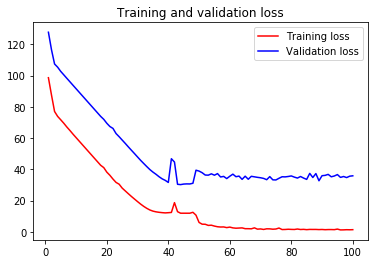

In [491]:
import matplotlib.pyplot as plt

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [492]:
results_1 = model_1.evaluate(TX_test, PMy_test)

164/164 [==============================] - 0s 369us/step


In [493]:
results_1/ np.mean(PMy_test)

0.4032023113459685

### LSTM

In [336]:
from keras.layers import LSTM

In [559]:
state_dim = 200
feat_num = 23

model_2 = Sequential()
model_2.add(LSTM(state_dim, input_shape=(None, feat_num),return_sequences=True, dropout=0.2))
model_2.add(LSTM(state_dim, return_sequences=True, dropout=0.2))
model_2.add(LSTM(state_dim, return_sequences=True, dropout=0.2))
model_2.add(LSTM(state_dim, return_sequences=False, dropout=0.2))
model_2.add(Dense(1))

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_125 (LSTM)              (None, None, 200)         179200    
_________________________________________________________________
lstm_126 (LSTM)              (None, None, 200)         320800    
_________________________________________________________________
lstm_127 (LSTM)              (None, None, 200)         320800    
_________________________________________________________________
lstm_128 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 201       
Total params: 1,141,801
Trainable params: 1,141,801
Non-trainable params: 0
_________________________________________________________________


In [560]:
model_2.compile(optimizer=RMSprop(), loss='mae')

In [561]:
history_2 = model_2.fit(TX_train, PMy_train,
                                epochs=50,
                                batch_size=8,
                                validation_data= (TX_valid, PMy_valid),
                                verbose=False)
print("I'm ready to fly, my dear Rossano")

I'm ready to fly, my dear Rossano


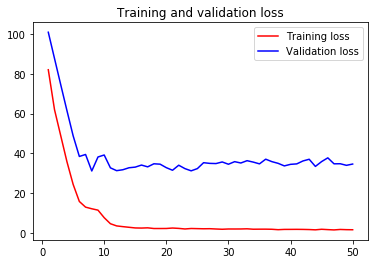

In [562]:
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [563]:
results_2 = model_2.evaluate(TX_test, PMy_test)

164/164 [==============================] - 0s 433us/step


In [564]:
results_2/ np.mean(PMy_test)

0.39464899417884197

### Bidirectional LSTM

In [494]:
from keras.layers import Bidirectional

In [573]:
state_dim = 200
feat_num = 23

model_3 = Sequential()
model_3.add(Bidirectional(LSTM(state_dim, return_sequences=True, dropout=0.2),
                         input_shape=(None, feat_num)))
model_3.add(Bidirectional(LSTM(state_dim, return_sequences=True, dropout=0.2)))
model_3.add(Bidirectional(LSTM(state_dim, return_sequences=False, dropout=0.2)))
model_3.add(Dense(1))


model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_31 (Bidirectio (None, None, 400)         358400    
_________________________________________________________________
bidirectional_32 (Bidirectio (None, None, 400)         961600    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 400)               961600    
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 401       
Total params: 2,282,001
Trainable params: 2,282,001
Non-trainable params: 0
_________________________________________________________________


In [574]:
model_3.compile(optimizer=RMSprop(), loss='mae')

In [575]:
history_3 = model_3.fit(TX_train, PMy_train,
                                epochs=10,
                                batch_size=8,
                                validation_data= (TX_valid, PMy_valid),
                                verbose=False)
print("I'm ready to fly, my dear Rossano")

I'm ready to fly, my dear Rossano


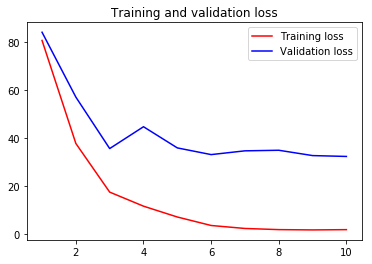

In [576]:
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [577]:
results_2 = model_3.evaluate(TX_test, PMy_test)

164/164 [==============================] - 0s 1ms/step


In [578]:
results_2/ np.mean(PMy_test)

0.3831999261022665

## Conclusions